In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine, func, inspect, MetaData, Column, Integer, Table
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [2]:
url = 'https://mbawa1139.github.io/ETL-Project/motorcycle_accident.html'

In [3]:
tbl = pd.read_html(url)
df = tbl[0]
df = df.drop(df.columns[0], axis=1)
df = df[df["Age_of_Casualty"] != -1]
df

,Accident_Index,Vehicle_Type,Longitude,Latitude,Sex_of_Casualty,Age_of_Casualty
0,201001BS70008,Motorcycle,-0.175802,51.484361,Male,28
1,201001BS70011,Motorcycle,-0.217699,51.514321,Male,21
2,201001BS70016,Motorcycle,-0.173157,51.485669,Male,14
4,201001BS70020,Motorcycle,-0.195276,51.494554,Male,23
5,201001BS70022,Motorcycle,-0.185327,51.494761,Male,37
...,...,...,...,...,...,...
114277,2014984120014,Motorcycle,-3.261808,54.987381,Male,25
114278,2014984121914,Motorcycle,-3.507553,55.408030,Male,59
114279,2014984127714,Motorcycle,-3.479810,55.118296,Male,42
114280,2014984129614,Motorcycle,-3.369973,55.352170,Male,35


In [4]:
df["Year"] = df["Accident_Index"].str[:4]

df = df[['Accident_Index', 'Year','Vehicle_Type', 'Longitude', 
    'Latitude', 'Sex_of_Casualty', 'Age_of_Casualty']]
df

,Accident_Index,Year,Vehicle_Type,Longitude,Latitude,Sex_of_Casualty,Age_of_Casualty
0,201001BS70008,2010,Motorcycle,-0.175802,51.484361,Male,28
1,201001BS70011,2010,Motorcycle,-0.217699,51.514321,Male,21
2,201001BS70016,2010,Motorcycle,-0.173157,51.485669,Male,14
4,201001BS70020,2010,Motorcycle,-0.195276,51.494554,Male,23
5,201001BS70022,2010,Motorcycle,-0.185327,51.494761,Male,37
...,...,...,...,...,...,...,...
114277,2014984120014,2014,Motorcycle,-3.261808,54.987381,Male,25
114278,2014984121914,2014,Motorcycle,-3.507553,55.408030,Male,59
114279,2014984127714,2014,Motorcycle,-3.479810,55.118296,Male,42
114280,2014984129614,2014,Motorcycle,-3.369973,55.352170,Male,35


In [5]:
# Create the decade bins 
bins = [0, 17, 25, 29, 39, 49, 60]

# Create the names for the bins
group_names = ["Under 18", "18 to 25", "26 to 35", "36 to 45", "46 to 55", "Over 55"]

# coverting year column datatype to interger
df['Age_of_Casualty'] = df['Age_of_Casualty'].astype(int)

# add bin column to dataframe
df["Age_Group"] = pd.cut(df["Age_of_Casualty"], bins, labels=group_names, include_lowest=True)

# reorganize columns
df = df[['Accident_Index', 'Year','Vehicle_Type', 'Longitude', 
         'Latitude', 'Sex_of_Casualty', 'Age_of_Casualty', 'Age_Group']]

df

,Accident_Index,Year,Vehicle_Type,Longitude,Latitude,Sex_of_Casualty,Age_of_Casualty,Age_Group
0,201001BS70008,2010,Motorcycle,-0.175802,51.484361,Male,28,26 to 35
1,201001BS70011,2010,Motorcycle,-0.217699,51.514321,Male,21,18 to 25
2,201001BS70016,2010,Motorcycle,-0.173157,51.485669,Male,14,Under 18
4,201001BS70020,2010,Motorcycle,-0.195276,51.494554,Male,23,18 to 25
5,201001BS70022,2010,Motorcycle,-0.185327,51.494761,Male,37,36 to 45
...,...,...,...,...,...,...,...,...
114277,2014984120014,2014,Motorcycle,-3.261808,54.987381,Male,25,18 to 25
114278,2014984121914,2014,Motorcycle,-3.507553,55.408030,Male,59,Over 55
114279,2014984127714,2014,Motorcycle,-3.479810,55.118296,Male,42,46 to 55
114280,2014984129614,2014,Motorcycle,-3.369973,55.352170,Male,35,36 to 45


In [7]:
age_group_df = df.groupby(["Age_Group"])["Age_of_Casualty"].count()
age_group_df

Age_Group
Under 18    13440
18 to 25    30542
26 to 35    10080
36 to 45    19711
46 to 55    20022
Over 55     13075
Name: Age_of_Casualty, dtype: int64

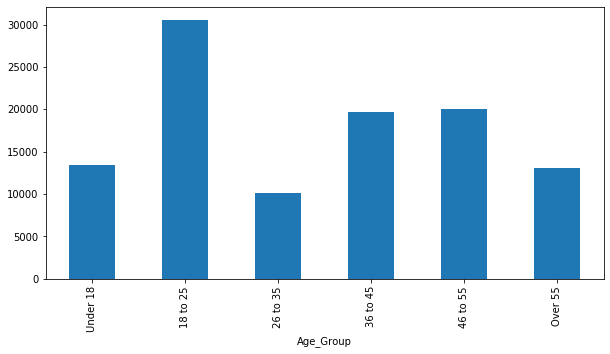

In [8]:
age_group_df.plot(kind="bar", figsize=(10,5))

In [9]:
# Path to SQLite file
sql_lite = "sqlite:///uk_motorcycle_accidents_sqlite.sqlite"

# Initial DB connection
engine = create_engine(sql_lite)

In [10]:
# Read DF into DB
df.to_sql(name='uk_motorcycle_accidents', con=engine, if_exists='append', index=False)

In [11]:
# Check connection of DB is working
engine.table_names()

['uk_motorcycle_accidents']

In [12]:
# Read DF into Json
df.to_json(r'uk_motorcycle_accidents.json', orient='index')

In [13]:
pd.read_sql_query('Select * from uk_motorcycle_accidents', con=engine).head()

,Accident_Index,Year,Vehicle_Type,Longitude,Latitude,Sex_of_Casualty,Age_of_Casualty,Age_Group
0,201001BS70008,2010,Motorcycle,-0.175802,51.484361,Male,28,26 to 35
1,201001BS70011,2010,Motorcycle,-0.217699,51.514321,Male,21,18 to 25
2,201001BS70016,2010,Motorcycle,-0.173157,51.485669,Male,14,Under 18
3,201001BS70020,2010,Motorcycle,-0.195276,51.494554,Male,23,18 to 25
4,201001BS70022,2010,Motorcycle,-0.185327,51.494761,Male,37,36 to 45


In [14]:
# Checking for table columns
inspector = inspect(engine)
casualty_columns = inspector.get_columns('uk_motorcycle_accidents')
for c in casualty_columns:
    print(c['name'], c["type"])

Accident_Index TEXT
Year TEXT
Vehicle_Type TEXT
Longitude FLOAT
Latitude FLOAT
Sex_of_Casualty TEXT
Age_of_Casualty BIGINT
Age_Group TEXT


In [15]:
session = Session(engine)

In [16]:
# Good example of querying the database and assigning to variable
coord = session.execute('Select Latitude, Longitude From uk_motorcycle_accidents Where Age_Group = "18 to 25" LIMIT 10').fetchall()
print(coord)

[(51.514321, -0.21769899999999998), (51.494554, -0.195276), (51.494743, -0.195845), (51.487021, -0.179153), (51.492443, -0.163523), (51.501665, -0.184044), (51.490444000000004, -0.191117), (51.499958, -0.19578299999999998), (51.484044, -0.18431199999999998), (51.502165999999995, -0.158521)]


In [17]:
session.close()